In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
positive_class_path = 'malaria/uab curated/1'
negative_class_path = 'malaria/uab curated/0'



- Need to see how results differ, when I choose to do greyscale conversion
- Will need to change this resize parameter

In [98]:
image_array = []

def file_append(class_path):    
    curr_path = os.path.join(os.getcwd(),class_path)
    cnt = 0
    file_list = [k for k in os.listdir(curr_path) if '.png' in k]
    for x in file_list:
        
        img_path = os.path.join(curr_path,x)

        img = imread(img_path)
#         img = rgb2gray(img)
        img = resize(img,(50,50,3))     ## Will need to change this resize parameter
        img = img.flatten()
        image_array.append(img)
        
    return image_array
    

pos_imgs = file_append(positive_class_path)
positive_df  = pd.DataFrame(pos_imgs)
positive_df['y'] = 1

neg_imgs = file_append(negative_class_path)
neg_df  = pd.DataFrame(neg_imgs)
neg_df['y'] = 0

# plt.imshow(np.reshape(pos_imgs[2],(40,40,3)))
df = pd.concat([positive_df,neg_df],ignore_index=True)

## Splitting entire dataset into train and test sets

In [100]:
X,y = df[df.columns[:-1]],df['y']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=121)


### Dimensionality reduction

In [101]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [102]:
scaler = StandardScaler()
image_array = scaler.fit_transform(X_train)

In [103]:
pca = PCA(n_components=0.80)
pca_data = pca.fit_transform(image_array)
exp_var = pca.explained_variance_ratio_

In [104]:
pca_data.shape

(2519, 59)

In [105]:
PC_labels = ['PC_'+ str(x) for x in range(1,60)]

0.8014309991955885

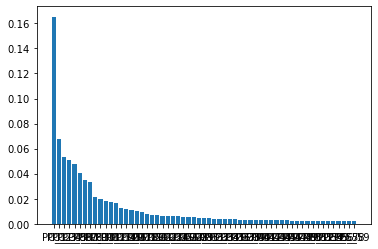

In [106]:
plt.bar(PC_labels,exp_var[:60])
sum(exp_var[:60])

In [107]:
pca_data.shape

(2519, 59)

## SVM Modelling

In [108]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [109]:
X_test_sc = scaler.transform(X_test)
X_test_new = pca.transform(X_test_sc)

In [110]:
model = SVC(C=0.1,kernel='sigmoid')
model.fit(pca_data,y_train)

accuracy_score(y_test,model.predict(X_test_new))


0.6925925925925925

In [81]:
# print(model.score(pca_data,y_train))


0.7041666666666667

In [16]:
np.linspace(0.05,10,20)

array([ 0.05      ,  0.57368421,  1.09736842,  1.62105263,  2.14473684,
        2.66842105,  3.19210526,  3.71578947,  4.23947368,  4.76315789,
        5.28684211,  5.81052632,  6.33421053,  6.85789474,  7.38157895,
        7.90526316,  8.42894737,  8.95263158,  9.47631579, 10.        ])

## SVM modelling with grid search CV

In [111]:
# parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.01,0.1,0.5,1]}
# grid_svc = SVC()
# clf = GridSearchCV(grid_svc, parameters,verbose=2,n_jobs=-1)


parameters = {'kernel':['poly'], 'C':[0.01,0.05, 0.1,0.5,1,10]}
grid_svc = SVC()
clf = GridSearchCV(grid_svc, parameters,verbose=2,n_jobs=-1)



In [112]:
clf.fit(pca_data, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10],
                         'kernel': ['poly']},
             verbose=2)

In [114]:
clf.best_score_

0.7169514658083246

In [28]:
# import pickle
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

# # some time later...

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)


clf.best_estimator_

SVC(C=0.01, kernel='poly')

In [30]:
clf.best_score_

0.7169514658083246